This code is written by Kuba Jerzmanowski
This code is inspired and based on strongly from Andrej Karpathy Micro Grad Video

In [1]:
import math
import random
import numpy as np

In [2]:
class Scalar:
    def __init__(self, data, _children=(), _op=''): 
        self.data = data
        self.grad = 0
        self.op = _op
        self._backward = lambda: None
        self._prev = set(_children)
    
    def __repr__(self):
        return f'Scalar(data={self.data}, grad={self.grad})'
    
    def __add__(self, other):  #define add and the back prob for it 
        other = other if isinstance(other, Scalar) else Scalar(other) #this helps so we can pass in raw numbers
        out = Scalar(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward
        return out
    
    def __radd__(self, other): #so the sum() works
        return self + other
    
    def __mul__(self, other): #define multiplication and the back prob for it 
        other = other if isinstance(other, Scalar) else Scalar(other)
        out = Scalar(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def __neg__(self): 
        return self * -1

    def __sub__(self, other):
        return self + (-other)
    
    def __truediv__(self, other):
        return self * (other**-1)
    
    def __rmul__(self, other):
        return self * other
    

    def __pow__(self, other):
        out = Scalar(self.data ** other, (self, ), f'^{other}')

        def _backward():
            self.grad += out.grad * (other * (self.data**(other-1)))
        out._backward = _backward
        return out
 
    def tanh(self):
        t = (math.exp(2*self.data)-1)/(math.exp(2*self.data) + 1)
        out = Scalar(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1- t**2) * out.grad
        out._backward = _backward
        return out
    
    def relu(self):
        out = Scalar(0 if self.data < 0 else self.data, (self,), 'relu')

        def _backward():
            self.grad += (out.data > 0) * out.grad
        out._backward = _backward
        return out
    

    def sigmoid(self):
        s = 1 / (1 + np.exp(-self.data))
        out = Scalar(s, (self,), 'sigmoid')

        def _backward():
            self.grad += s * (1 - s) * out.grad
        out._backward = _backward

        return out
    
    def backprop(self): #we first build up the topo list then reverse it since we backprop in reverse starting with the Scalar representing the Loss
        self.grad = 1

        chain = []
        seen = set()
        def build_list(node):
            if node not in seen:
                seen.add(node)
                for par in node._prev:
                    build_list(par)
                chain.append(node)

        build_list(self)
        for node in reversed(chain):
            node._backward()


Define the NN 

In [3]:
from typing import Any


class Neuron:
    def __init__(self, width, last=False):
        #each neuron has weights to where they are the input width and an additional bias
        self.w = [Scalar(random.uniform(-1,1)) for _ in range(width)]
        self.b = Scalar(0)
        self.last = last

    def __call__(self, x):
        #here we want to miltiply so we will zip the weights to do wx+b
        out = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        if self.last:
            return out
        return out.sigmoid()
    
    def params(self): #this function is nesscary so that we can later update each param after getting the grad
        return self.w + [self.b]
    
class Layer: #here we just move up another layer of abstraction where we will 
    def __init__(self, num_in, num_out, last=False):
        self.last = last
        self.neurons = [Neuron(num_in, last) for _ in range(num_out)]

    def __call__(self, x):
        out =  [n(x) for n in self.neurons]
        return out[0] if len(out) == 1 else out

    
    def params(self):
        params = []
        for n in self.neurons:
            p = n.params()
            params.extend(p)
        return params
    
class MLP: 
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [
            Layer(sz[i], sz[i+1], last=(i == len(nouts) - 1)) #thsis jsut so that the last layer does not have a actiation funtion
            for i in range(len(nouts))
        ]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def params(self):
        params = []
        for l in self.layers:
            p = l.params()
            params.extend(p)
        return params
    
    def zero_grad(self):
        params = self.params()
        for p in params:
            p.grad = 0
    



Def the Data

In [4]:
X = [
    [0.1, 1.2],
    [0.7, 1.8],
    [0.8, 1.6],
    [0.8, 0.6],
    [1.0, 0.8],
    [0.3, 0.5],
    [0.0, 0.2],
    [-0.3, 0.8],
    [-0.5, -1.5],
    [-1.5, -1.3]
]

Y = [
    [1,0],
    [1,0],
    [1,0],
    [0,0],
    [0,0],
    [1,1],
    [1,1],
    [1,1],
    [0,1],
    [0,1],
]

nn = MLP(2, [128,2])

In [5]:
Y_l = [
    1,
    1,
    1,
    0,
    0,
    3,
    3,
    3,
    2,
    2,
]

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def plot_decision_boundary(model, epoch):
    X_np = np.array(X)
    
    x_min, x_max = X_np[:, 0].min() - 1, X_np[:, 0].max() + 1
    y_min, y_max = X_np[:, 1].min() - 1, X_np[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))
    
    inp = np.c_[xx.ravel(), yy.ravel()]
    Z = np.zeros((inp.shape[0],))
    for i, p in enumerate(inp):
        out = model(p)
        out[0] = 0 if out[0].data < 0.5 else 1
        out[1] = 0 if out[1].data < 0.5 else 1
        if out == [0,0]:
            Z[i] = 0 
        elif out == [1,0]:
            Z[i] = 1       
        elif out == [0,1]:
            Z[i] = 2
        elif out == [1,1]:
            Z[i] = 3
    # Plot the decision boundary
    plt.figure(figsize=(10, 8))
    plt.tricontourf(inp[:, 0], inp[:, 1], Z, alpha=0.4, cmap=plt.cm.RdYlBu)
    plt.scatter(X_np[:, 0], X_np[:, 1], c=Y_l, cmap=plt.cm.RdYlBu, edgecolor='black')
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.title(f'Decision Boundary after {epoch} epochs')
    plt.colorbar()
    plt.show()

Define the loss function. We have to double unpack because y is 2 outputs

In [7]:
def loss():
    inputs = [[Scalar(x) for x in xrow] for xrow in X]
    y_trues = [[Scalar(y) for y in yrow] for yrow in Y]

    
    outs = [nn(xrow) for xrow in inputs] 
    # MSE loss
    losses = []
    for out, ytrue in zip(outs, y_trues):
        score0 = out[0] - ytrue[0]
        score1 = out[1] - ytrue[1]
        losses.append((score0*score0) + (score1*score1))

    data_loss = sum(losses) * (1.0 / len(losses))

    
    return data_loss



Train Looop

epoch:0 loss:6.83879256795092
epoch:1 loss:1.4368631223154935
epoch:2 loss:0.9425885810331556


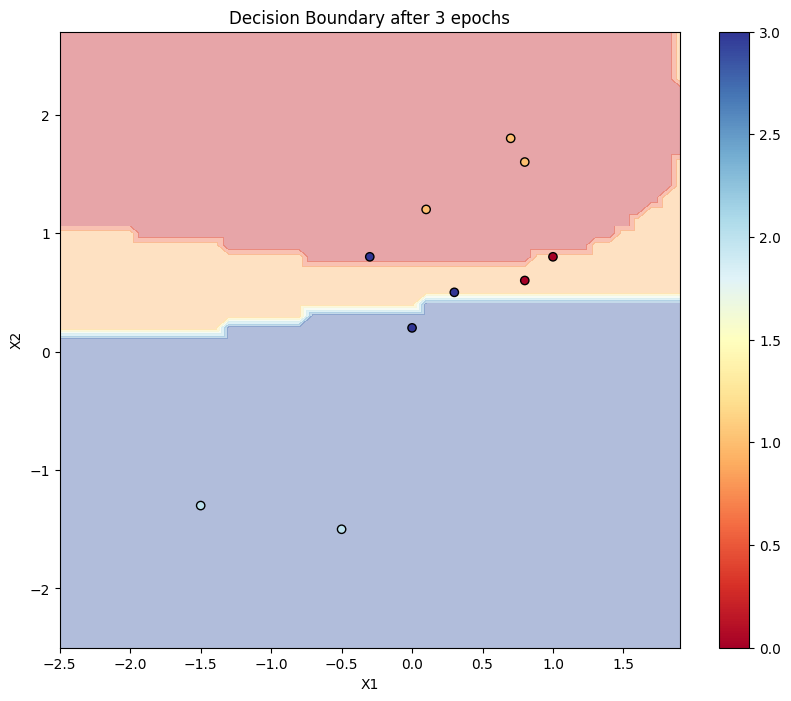

epoch:3 loss:0.8030495760451148
epoch:4 loss:0.7085703745601823
epoch:5 loss:0.6340160653687756
epoch:6 loss:0.5741883650293913
epoch:7 loss:0.525957742837442
epoch:8 loss:0.48691568642781075
epoch:9 loss:0.4551622294741031


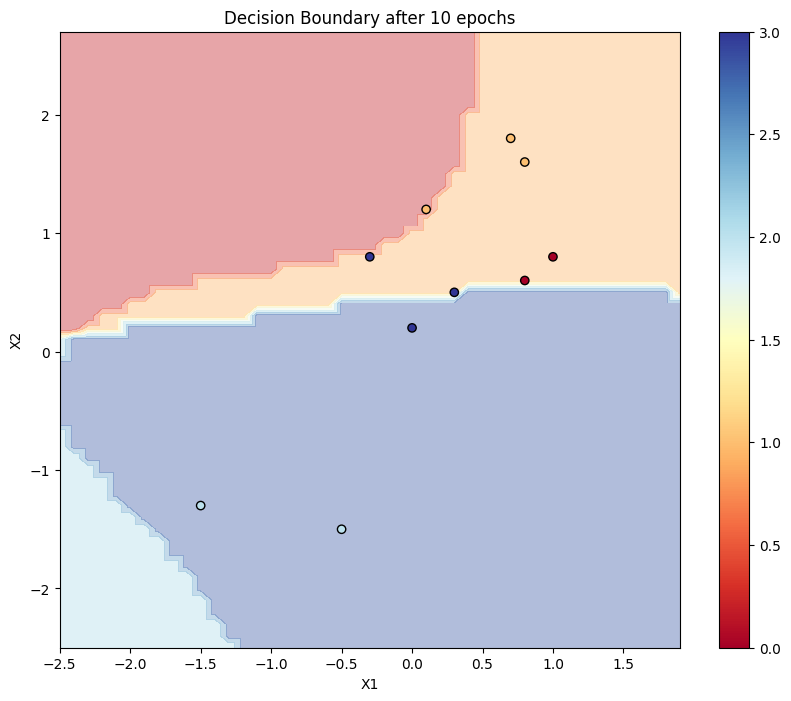

epoch:10 loss:0.4291950884760473
epoch:11 loss:0.4078259546685189
epoch:12 loss:0.3901146551660048
epoch:13 loss:0.37531716898495315
epoch:14 loss:0.3628445587101441
epoch:15 loss:0.35223051748925926
epoch:16 loss:0.34310571912982246
epoch:17 loss:0.33517754197737537
epoch:18 loss:0.3282140386257246
epoch:19 loss:0.3220312609615481
epoch:20 loss:0.3164832372691088
epoch:21 loss:0.3114540458256585
epoch:22 loss:0.3068515460001107
epoch:23 loss:0.30260241991965886
epoch:24 loss:0.2986482504752303
epoch:25 loss:0.29494241887745115
epoch:26 loss:0.29144765036496184
epoch:27 loss:0.2881340725408379
epoch:28 loss:0.2849776791698549
epoch:29 loss:0.2819591146871902
epoch:30 loss:0.27906271239358116
epoch:31 loss:0.27627573332688865
epoch:32 loss:0.2735877638824939
epoch:33 loss:0.270990239019286
epoch:34 loss:0.2684760648192623
epoch:35 loss:0.2660393196508039
epoch:36 loss:0.2636750175215489
epoch:37 loss:0.2613789206363276
epoch:38 loss:0.2591473908883145
epoch:39 loss:0.25697727215737554
e

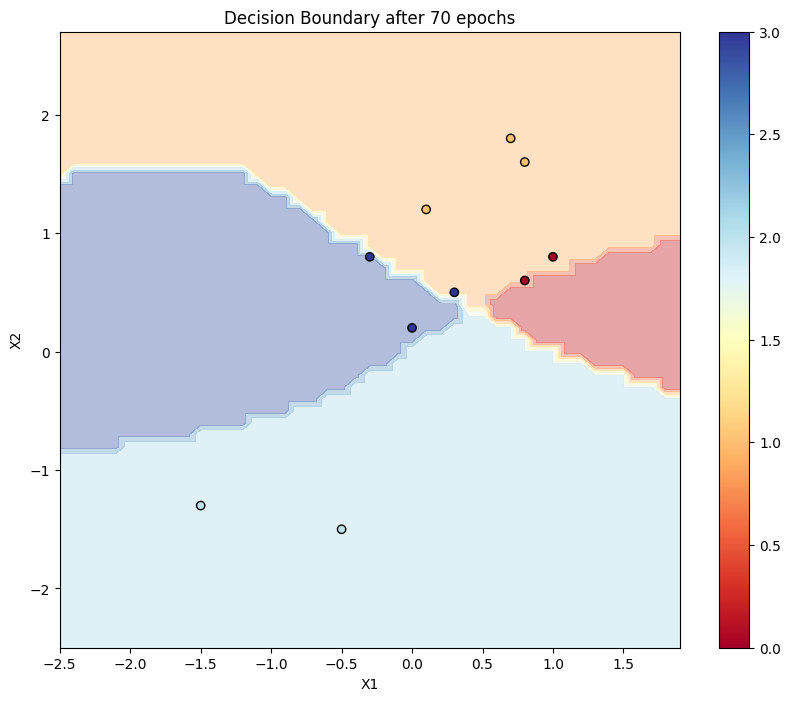

epoch:70 loss:0.21114303933326953
epoch:71 loss:0.21016918797223952
epoch:72 loss:0.2092183202768225
epoch:73 loss:0.2082898366173488
epoch:74 loss:0.2073831531899949
epoch:75 loss:0.2064977015782369
epoch:76 loss:0.20563292833058486
epoch:77 loss:0.20478829455316883
epoch:78 loss:0.20396327551604176
epoch:79 loss:0.2031573602721981
epoch:80 loss:0.20237005128850202
epoch:81 loss:0.20160086408782055
epoch:82 loss:0.2008493269017615
epoch:83 loss:0.20011498033349398
epoch:84 loss:0.19939737703019494
epoch:85 loss:0.19869608136470981
epoch:86 loss:0.1980106691260686
epoch:87 loss:0.1973407272185264
epoch:88 loss:0.19668585336881816
epoch:89 loss:0.1960456558413681
epoch:90 loss:0.1954197531611703
epoch:91 loss:0.19480777384412415
epoch:92 loss:0.19420935613457785
epoch:93 loss:0.19362414774987657
epoch:94 loss:0.19305180563170377
epoch:95 loss:0.19249199570402464
epoch:96 loss:0.19194439263744545
epoch:97 loss:0.19140867961979968
epoch:98 loss:0.19088454813280575
epoch:99 loss:0.19037169

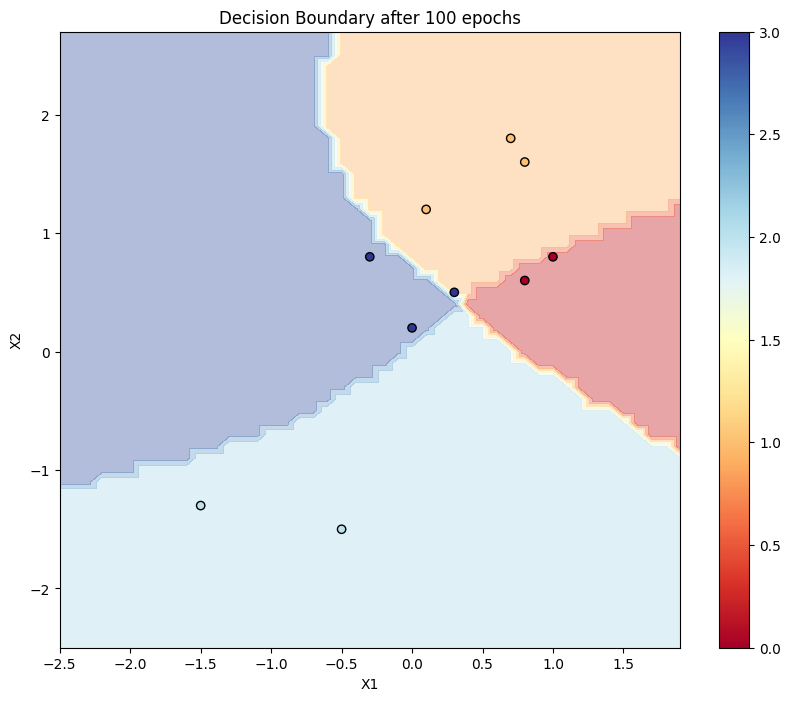

In [8]:
lossi = []
for epoch in range(100):
     # forward
    total_loss = loss()
    lossi.append(total_loss.data)
    print(f'epoch:{epoch} loss:{total_loss.data}')

    # backward
    nn.zero_grad()
    total_loss.backprop()
    
    # optim step
    learning_rate = 0.01
    for p in nn.params():
        p.data -= learning_rate * p.grad

    if epoch + 1 in [3, 10, 70, 100]:
         plot_decision_boundary(nn, epoch + 1)



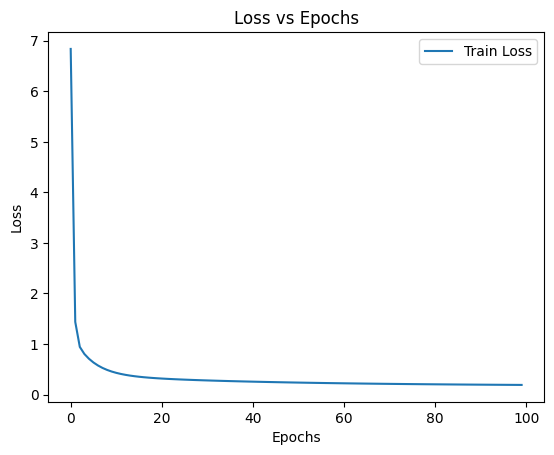

In [9]:
# Plot losses
plt.plot(lossi, label='Train Loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()